In [1]:
library(ggplot2)
library(reshape2)
library(grid)
library(gridExtra)

In [2]:
tab.gephi <- read.table("data/positive_edges_minabund500_mincorr0-8.csv", sep=",",header=TRUE)

In [3]:
comp.0 <- tab.gephi$id[tab.gephi$componentnumber == 0]
comp.2 <- tab.gephi$id[tab.gephi$componentnumber == 2]

In [4]:
metadata <- read.table("data/metadata.csv", sep="\t", header=TRUE, comment.char="")

In [5]:
grid_arrange_shared_legend <- function(..., ncol = length(list(...)), nrow = 1, position = c("bottom", "right")) {

  plots <- list(...)
  position <- match.arg(position)
  g <- ggplotGrob(plots[[1]] + theme(legend.position = position))$grobs
  legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
  lheight <- sum(legend$height)
  lwidth <- sum(legend$width)
  gl <- lapply(plots, function(x) x + theme(legend.position="none"))
  #gl <- c(gl, ncol = ncol, nrow = nrow)

  combined <- switch(position,
                     "bottom" = arrangeGrob(do.call(arrangeGrob, grobs=gl,layout_matrix=cbind(c(1,1,1,2))),
                                            legend,
                                            ncol = 1,
                                            heights = unit.c(unit(1, "npc") - lheight, lheight)),
                     "right" = arrangeGrob(do.call(arrangeGrob, list(grobs=gl,layout_matrix=cbind(c(1,1,1,2)))),
                                           legend,
                                           ncol = 2,
                                           widths = unit.c(unit(1, "npc") - lwidth, lwidth)))

  #grid.newpage()
  grid.draw(combined)

  # return gtable invisibly
  invisible(combined)

}

 [1] " p__Acidobacteria"    " p__Proteobacteria"   " p__Actinobacteria"  
 [4] " p__AD3"              " p__WPS-2"            " p__Bacteroidetes"   
 [7] " p__Verrucomicrobia"  " p__Chloroflexi"      " p__Gemmatimonadetes"
[10] " p__Cyanobacteria"    "Other"               


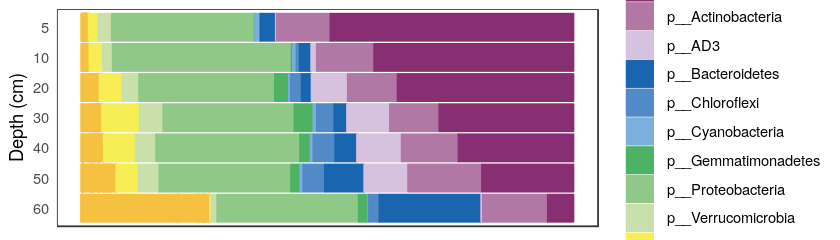

In [6]:
options(repr.plot.height=2)
otu.table <- read.table("data/otu_table.tab", sep="\t", header=TRUE, skip=1, comment.char="")
# Print out the component tables, normalized to relative abundance
otu.table.0 <- otu.table[otu.table$X.OTU.ID %in% comp.0,]
otu.table.2 <- otu.table[otu.table$X.OTU.ID %in% comp.2,]
otu.tax <- otu.table[,ncol(otu.table)]
otu.subtable <- otu.table[,2:ncol(otu.table)-1]
otu.col.sums <- colSums(otu.subtable)
otu.tax.sums <- rowSums(otu.subtable)
otu.table.0[,2:ncol(otu.table.0)-1] <- sweep(otu.table.0[,2:ncol(otu.table.0)-1],2,otu.col.sums,`/`)
otu.table.2[,2:ncol(otu.table.2)-1] <- sweep(otu.table.2[,2:ncol(otu.table.2)-1],2,otu.col.sums,`/`)
write.table(otu.table.0, "data/otu_table_mineral_layer_withinsample_relabundance.tab", sep="\t")
write.table(otu.table.2, "data/otu_table_organic_layer_withinsample_relabundance.tab", sep="\t")

#Function to strip out the lowest taxonomic level
lastTax <- function(x) {
    lT <- NULL
    for (i in 1:length(x)) {
        if (nchar(x[i]) > 4)
            lT <- x[i]
            }
    return(lT)
}
twoTax <- function(x) {
    return(x[2])
}
otu.lasttax <- vapply(strsplit(as.vector(otu.tax), ";"), twoTax, as.vector("A"))
m.otu.table <- melt(otu.subtable,id.vars=1)
m.otu.table$Depth <- metadata$soil_depth[match(m.otu.table$variable, metadata$sample.id)]
m.otu.table$Taxonomy <- vapply(strsplit(as.vector(otu.table$Consensus.Lineage[match(m.otu.table$X.OTU.ID, otu.table$X.OTU.ID)]), ";"), twoTax,as.vector("A"))

overall <- aggregate(m.otu.table$value, FUN=sum, by=list(Taxonomy=m.otu.table$Taxonomy))
colnames(overall) <- c("Taxonomy", "Abundance")
overall <- overall[order(overall$Abundance, decreasing=TRUE),]
#For phylum level
top10 <- overall$Taxonomy[1:10]
top10 <- c(top10, "Other")
#For class level, we take the unclassifieds (" c__") and put them into "Other"
#top10 <- overall$Taxonomy[1:11]
#top10 <- top10[top10!=' c__']
#top10 <- c(top10, "Other")
#For order level, we take the unclassifieds (" o__") and put them into "Other"
#top10 <- overall$Taxonomy[1:20]
#top10 <- top10[top10!=' p__']
#top10 <- top10[top10!=' c__']
tax <- aggregate(m.otu.table$value, FUN=sum, by=list(Depth=m.otu.table$Depth, Taxonomy=m.otu.table$Taxonomy))
tax$Taxonomy[! tax$Taxonomy %in% top10] <- "Other"
#tax<-tax[tax$Taxonomy!="Other",]
tax$Taxonomy <- factor(tax$Taxonomy, levels = top10[order(top10)])

depthUnique <- unique(tax$Depth)
tax$Depth <- factor(tax$Depth, levels = depthUnique[order(depthUnique,decreasing=TRUE)])
colnames(tax) <- c("Depth","Taxonomy","Abundance")
for (depth in unique(tax$Depth)) {
    dtax <- tax$Abundance[tax$Depth==depth]
    tax$Abundance[tax$Depth==depth] <- dtax/sum(dtax)
}
print(top10)
#tax$Abundance <- tax$Abundance/sum(tax$Abundance)
colours<-c("#882E72","#B178A6","#D6C1DE","#1965B0","#5289C7","#7BAFDE","#4EB265","#90C987","#CAE0AB","#F7EE55","#F6C141", "#F1932D","#E8601C","#DC050C")
#colours<-c("#771155","#AA4488","#CC99BB","#114477","#4477AA","#77AADD","#117777","#44AAAA","#77CCCC","#117744","#44AA77","#88CCAA","#777711","#AAAA44","#DDDD77","#774411","#AA7744","#DDAA77","#771122","#AA4455")#,"#DD7788")
p1<-ggplot(tax, aes(x=Depth, group=Taxonomy, y=Abundance, colour=Taxonomy, fill=Taxonomy))+geom_bar(stat='identity')+ theme(legend.position="bottom")+ylab("Relative Abundance")
p1<-p1+scale_fill_manual(values=colours)+scale_colour_manual(values=colours)+theme_bw()+theme(axis.text.y = element_text(angle=0), axis.text.x=element_blank(), axis.title.x=element_blank(), axis.ticks=element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())+xlab("Depth (cm)")+coord_flip()+ guides(fill = guide_legend(ncol = 1))
p1

In [7]:
otu.table.0 <- otu.table[otu.table$X.OTU.ID %in% comp.0,2:ncol(otu.table)-1]
otu.table.2 <- otu.table[otu.table$X.OTU.ID %in% comp.2,2:ncol(otu.table)-1]
otu.table.0.sums <- colSums(otu.table.0)
otu.table.2.sums <- colSums(otu.table.2)
otu.0.tax <- otu.table[otu.table$X.OTU.ID %in% comp.0, ncol(otu.table)]
otu.2.tax <- otu.table[otu.table$X.OTU.ID %in% comp.2, ncol(otu.table)]
otu.0.tax.sums <- rowSums(otu.table.0)
otu.2.tax.sums <- rowSums(otu.table.2)
otu.0.lasttax <- vapply(strsplit(as.vector(otu.0.tax), ";"), twoTax, as.vector("A"))
otu.2.lasttax <- vapply(strsplit(as.vector(otu.2.tax), ";"), twoTax, as.vector("A"))

               Taxonomy    Abundance Component
1      p__Acidobacteria 0.1789735047   Mineral
2     p__Actinobacteria 0.0867309029   Mineral
3                p__AD3 0.1732695994   Mineral
4      p__Bacteroidetes 0.0398596961   Mineral
5           p__Chlorobi 0.0070861831   Mineral
6        p__Chloroflexi 0.0560117199   Mineral
7      p__Cyanobacteria 0.0035363945   Mineral
8         p__Firmicutes 0.0122409275   Mineral
9   p__Gemmatimonadetes 0.0496622159   Mineral
10       p__Nitrospirae 0.0072325143   Mineral
11    p__Proteobacteria 0.2779309363   Mineral
12   p__Verrucomicrobia 0.0520862249   Mineral
13             p__WPS-2 0.0553791804   Mineral
14     p__Acidobacteria 0.5995961633   Organic
15    p__Actinobacteria 0.1195803074   Organic
16   p__Armatimonadetes 0.0007217234   Organic
17     p__Bacteroidetes 0.0146307421   Organic
18    p__Proteobacteria 0.2502935770   Organic
19   p__Verrucomicrobia 0.0132989020   Organic
20             p__WPS-2 0.0018785847   Organic
             

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange   gtable[arrange]
2 2 (1-1,2-2) arrange gtable[guide-box]

png 
  2

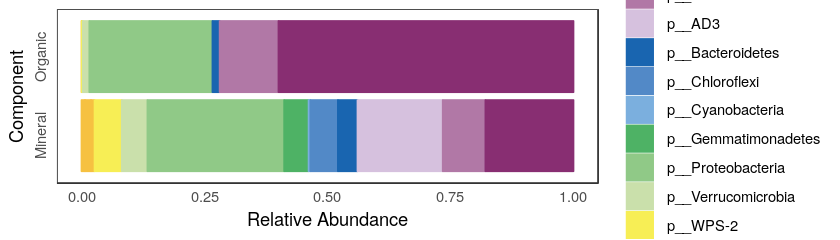

In [8]:
tax.0 <- data.frame(Taxonomy=otu.0.lasttax, Abundance = otu.0.tax.sums)
tax.2 <- data.frame(Taxonomy=otu.2.lasttax, Abundance = otu.2.tax.sums)
tax.0 <- aggregate(tax.0$Abundance, FUN=sum, by=list(Taxonomy=tax.0$Taxonomy))
colnames(tax.0) <- c("Taxonomy","Abundance")
#tax.0 <- tax.0[tax.0$Taxonomy %in% top10,]
tax.0$Abundance <- tax.0$Abundance/sum(tax.0$Abundance)
tax.2 <- aggregate(tax.2$Abundance, FUN=sum, by=list(Taxonomy=tax.2$Taxonomy))
colnames(tax.2) <- c("Taxonomy","Abundance")
#tax.2 <- tax.2[tax.2$Taxonomy %in% top10,]
tax.2$Abundance <- tax.2$Abundance/sum(tax.2$Abundance)
taxdf <- rbind(tax.0, tax.2)
taxdf$Component <- c(rep("Mineral", length(tax.0$Abundance)), rep("Organic", length(tax.2$Abundance)))
taxdf$Taxonomy <- as.vector(taxdf$Taxonomy)
print(taxdf)
taxdf$Taxonomy[! taxdf$Taxonomy %in% top10] <- "Other"
taxdf$Taxonomy <- factor(taxdf$Taxonomy, levels = top10[order(top10)])
print(taxdf)
pdf("phylum_bar_rotated_top10.pdf", height=6,width=6)
colours<-c("#882E72","#B178A6","#D6C1DE","#1965B0","#5289C7","#7BAFDE","#4EB265","#90C987","#CAE0AB","#F7EE55","#F6C141")#,"#F1932D","#E8601C","#DC050C")
#colours<-c("#771155","#AA4488","#CC99BB","#114477","#4477AA","#77AADD","#117777","#44AAAA","#77CCCC","#117744","#44AA77","#88CCAA","#777711","#AAAA44","#DDDD77","#774411","#AA7744","#DDAA77","#771122","#AA4455")#,"#DD7788")
p2<-ggplot(taxdf, aes(x=Component, group=Taxonomy, y=Abundance, colour=Taxonomy, fill=Taxonomy))+geom_bar(stat='identity')+ theme(legend.position="bottom")+ylab("Relative Abundance")
p2<-p2+scale_fill_manual(values=colours,drop=FALSE)+scale_colour_manual(values=colours,drop=FALSE)+theme_bw()+theme(axis.ticks=element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), axis.text.y = element_text(angle=90, hjust=0.5))+coord_flip()
pfull<-grid_arrange_shared_legend(p1,p2,ncol=1,nrow=4,position='right')
pfull
dev.off()
p2

In [9]:
melt.0 <- melt(otu.table.0.sums[2:length(otu.table.0.sums)])
melt.2 <- melt(otu.table.2.sums[2:length(otu.table.2.sums)])

In [10]:
melt.0$Depth <- metadata[match(rownames(melt.0), metadata[,1]), "soil_depth"]
melt.2$Depth <- metadata[match(rownames(melt.2), metadata[,1]), "soil_depth"]

In [11]:
colnames(melt.0) <- c("Abundance", "Depth")
colnames(melt.2) <- c("Abundance", "Depth")

In [12]:
se <- function(x) {
    sem <- sd(x)/sqrt(length(x))
    return(sem)
}

png 
  2

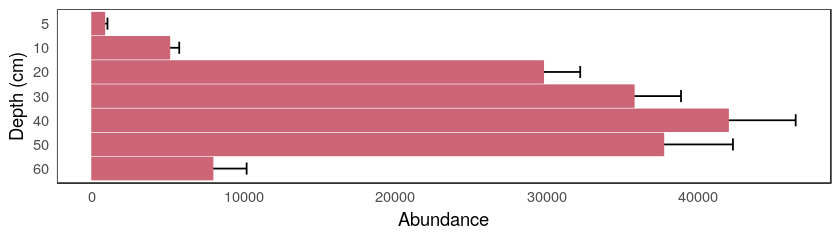

In [13]:
#0 must be green
#Convert to means and sd
melt.0.mean <- aggregate(melt.0$Abundance, by=list(Depth=melt.0$Depth), FUN=mean)
colnames(melt.0.mean) <- c("Depth", "Mean")
melt.0.se <- aggregate(melt.0$Abundance, by=list(Depth=melt.0$Depth), FUN=se)
melt.0.mean$SE <- melt.0.se$x
melt.0.mean$Depth <- factor(melt.0.mean$Depth, levels=unique(melt.0.mean$Depth)[order(unique(melt.0.mean$Depth),decreasing=TRUE)])
p <- ggplot(melt.0.mean, aes(x=as.factor(Depth), y=Mean)) + geom_errorbar(aes(ymin=Mean-SE, ymax=Mean+SE,width=0.5)) + geom_bar(position=position_dodge(), stat='identity', fill='#CC6677', col='#CC6677')
p <- p + xlab("Depth (cm)") + ylab("Abundance")+theme_bw()+theme(axis.ticks=element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())+coord_flip()
pdf("Mineral_layer_inset.pdf", height=3, width=3)
p
dev.off()
p

png 
  2

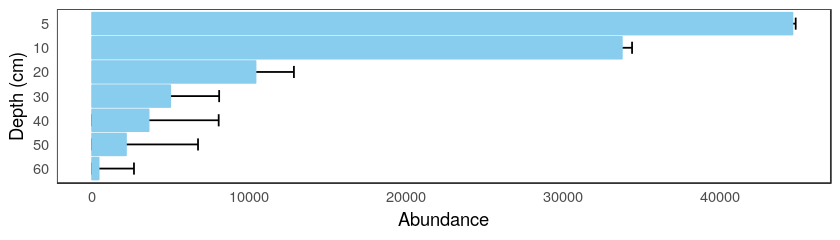

In [14]:
#0 must be pink
#Convert to means and sd
melt.2.mean <- aggregate(melt.2$Abundance, by=list(Depth=melt.2$Depth), FUN=mean)
colnames(melt.2.mean) <- c("Depth", "Mean")
melt.2.se <- aggregate(melt.0$Abundance, by=list(Depth=melt.2$Depth), FUN=se)
melt.2.mean$SEU <- melt.2.mean$Mean + melt.2.se$x
melt.2.mean$SEL <- melt.2.mean$Mean - melt.2.se$x
melt.2.mean$SEL[melt.2.mean$SEL < 0] <- 0
melt.2.mean$Depth <- factor(melt.2.mean$Depth, levels=unique(melt.2.mean$Depth)[order(unique(melt.2.mean$Depth),decreasing=TRUE)])
p <- ggplot(melt.2.mean, aes(x=as.factor(Depth), y=Mean)) + geom_errorbar(aes(ymin=SEL, ymax=SEU, width=0.5)) + geom_bar(position=position_dodge(), stat='identity', fill='#88CCEE', col='#88CCEE')
p <- p + xlab("Depth (cm)") + ylab("Abundance")+theme_bw()+theme(axis.ticks=element_blank(),panel.grid.major = element_blank(), panel.grid.minor = element_blank())+coord_flip()
pdf("Organic_layer_inset.pdf", height=3, width=3)
p
dev.off()
p

In [15]:
#Percentage of Unclassified OTUs by sequence count
sum(otu.table[otu.table$Consensus.Lineage=="Unclassified",2:ncol(otu.table)-1])/sum(otu.table[,2:ncol(otu.table)-1])*100
#Percentage of Unclassified OTUs
dim(otu.table[otu.table$Consensus.Lineage=="Unclassified",])[1]/dim(otu.table)[1]*100

[1] 0.1796564

[1] 0.1837196

In [16]:
sessionInfo()

R version 3.4.4 (2018-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gridExtra_2.3  reshape2_1.4.3 ggplot2_3.1.0 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.19         pillar_1.3.0         compiler_3.4.4      
 [4] plyr_1.8.4           bindr_0.1.1          base64enc_0.1-3     
 [7] tools_3.4.4          d